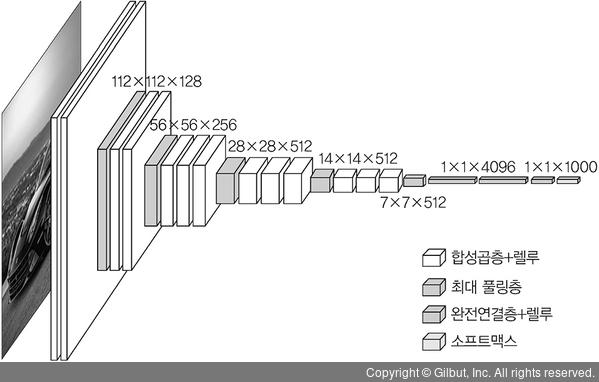
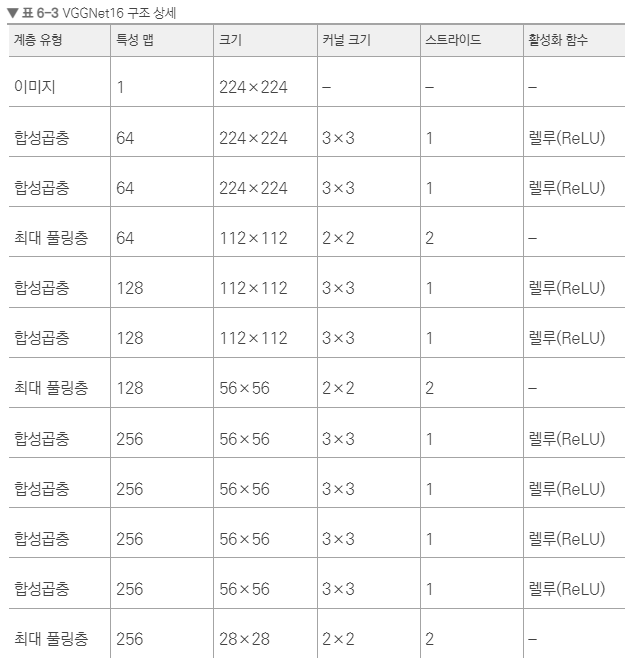
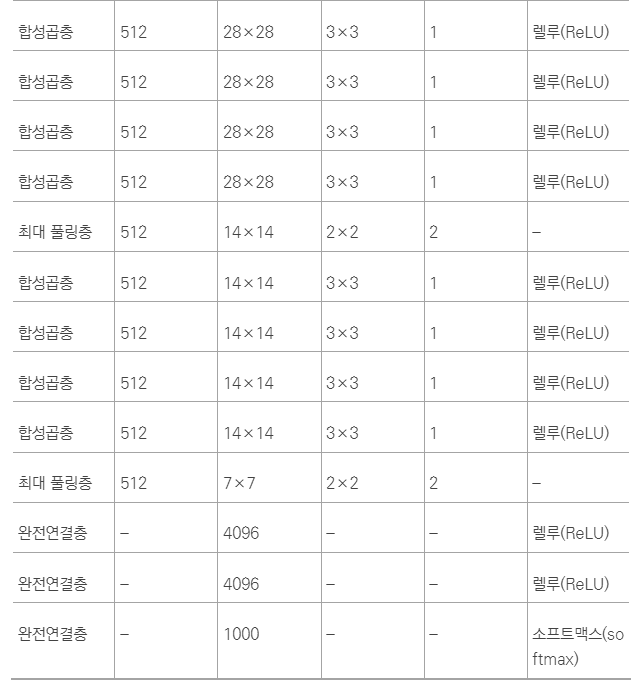

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 코드 6-14 필요한 라이브러리 호출
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 # 얼굴 인식, 물체 식별, 이미지 결합 등 작업이 가능한 오픈 소스 라이브러리

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

2024-12-03 01:34:47.999615: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 01:34:48.001679: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 01:34:48.008393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733157288.019063  103529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733157288.022040  103529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 01:34:48.033946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# 코드 6-15 VGG19 네트워크 생성
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(
            Conv2D(
                64,
                kernel_size=(3, 3),
                padding="same",
                activation="relu",
                input_shape=input_shape,
            )
        )
        self.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu"))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Flatten())
        self.add(Dense(4096, activation="relu"))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation="relu"))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation="softmax"))

        self.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

In [4]:
# 코드 6-16 VGG19 모델 출력
model = VGG19(input_shape=(224, 224, 3))
model.summary()

/home/halozhan/Study/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1733157299.014447  103529 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 코드 6-17 사전 훈련된 VGG19 가중치 내려받기 및 클래스 정의
# 사전 훈련된 VGG19 모델의 가중치 내려받기
model.load_weights("../chap6/data/vgg19_weights_tf_dim_ordering_tf_kernels.h5")
# 검증용으로 사용될 클래스 세 개만 적용했으며, 전체 이미지에 대한 클래스는 “../chap6/data/”에 위치한 classes.txt 파일을 참고하세요.
classes = {
    282: "cat",
    681: "notebook, notebook computer",
    970: "alp",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Text(0.5, 1.0, 'cat')

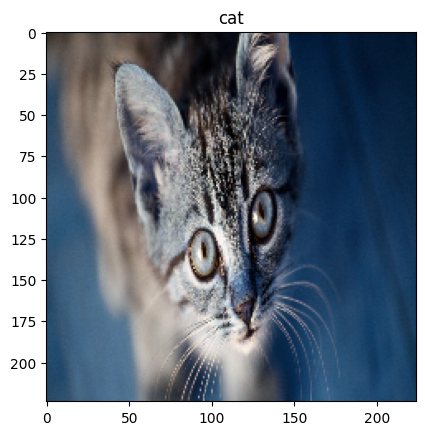

In [6]:
# 코드 6-18 이미지 호출 및 예측
# image1 = cv2.imread("../chap6/data/labtop.jpg")
# image1 = cv2.imread("../chap6/data/starrynight.jpeg")
image1 = cv2.imread("../chap6/data/cat.jpg")

image1 = cv2.resize(image1, (224, 224))
plt.figure()  # 새로운 창 생성
plt.imshow(image1)  # 이미지 출력
image1 = image1[np.newaxis, :]  # 차원 확장(행을 추가)
predicted_value = model.predict(image1)
predicted_value = np.argmax(predicted_value)
plt.title(classes[int(predicted_value)])  # 출력에 대한 title(제목) 지정